In [1]:
# preamble
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as ss
import tensorflow as tf
import tensorflow_probability as tfp

from scipy.optimize import minimize


## Let's start by comparing Laplace and Variational approximations.

We'll approximate a mixture of two Cauchy distributions with a normal distribution, using both methods.

Our target distribution is

$P(\theta) = \rho\left(\frac{1}{\pi \gamma \left(1+\left(\frac{\theta-\mu_1}{\gamma}\right)^2\right)}\right)
+ (1-\rho)\left(\frac{1}{\pi \gamma \left(1+\left(\frac{\theta-\mu_2}{\gamma}\right)^2\right)}\right)
$

where $\mu_1=-2$, $\mu_2 = 2$, $\gamma=1$ and $\rho=0.6$.

Below, we'll write a function to evaluate $\log P(\theta)$.


In [2]:
def mixture_log_pdf(theta, rho, mu1, mu2, gamma):
    lp1 = np.log(rho) + ss.cauchy.logpdf(theta, loc=mu1, scale=gamma)
    lp2 = np.log(1-rho) + ss.cauchy.logpdf(theta, loc=mu2, scale=gamma)
    lp = np.logaddexp(lp1, lp2)
    return lp

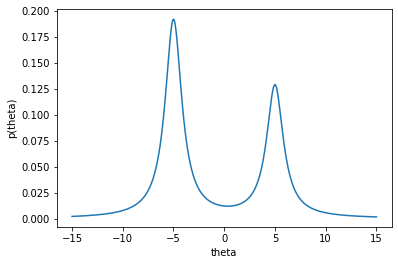

In [3]:
mu1 = -5.
mu2 = 5.
rho = 0.6
gamma = 1.
theta = np.linspace(-15, 15, 1000)
p_theta = np.exp(mixture_log_pdf(theta, rho=rho, mu1=mu1, mu2=mu2, gamma=gamma))

plt.plot(theta, p_theta)
plt.xlabel('theta')
plt.ylabel('p(theta)')
plt.show()

## What do you think the Laplace solution will end up looking like?

Add your expectations here

## What's the maximizing value of log(P)?

You should be able to tell from the distribution, but if not, then you can use the minimize function from scipy.optimize

In [4]:
max_val = mu1 ## fill in manually, or calculate

## We need to compute the second derivative of log(P).

Doing it analytically is going to be ugly, because the log doesn't have a nice form

(although, is there an approximate log distribution we could take the second derivative of?)

So, we're going to use automatic differentiation via TensorFlow. We'll use the `tf.hessians()` function, since later on, we're going to be working with non-scalar data.

In [5]:
# calculate hessian using TF/autodiff

# first create a variable wrapper for the MAP, for calculating gradients
max_theta = tf.Variable([max_val], dtype=tf.float32)

# specify distribution
target_dist = tfp.distributions.Mixture( # mixture of distributions
    cat=tfp.distributions.Categorical(probs=[rho, 1.-rho]), # mixing proportions
    components=[
        tfp.distributions.Cauchy(loc=mu1, scale=gamma), # first mixture component
        tfp.distributions.Cauchy(loc=mu2, scale=gamma)  # second mixture component
    ]
)

# target: -log(P(theta))
neg_log_prob = -1. * (target_dist.log_prob(value=max_theta))

hess = tf.hessians(neg_log_prob, max_theta)
with tf.Session() as sess:
    sess.run(fetches=tf.global_variables_initializer())
    hess_val = sess.run(fetches=[hess])

hess_val = np.squeeze(hess_val)

std_est = 1./np.sqrt(hess_val)

print('approximate with a Normal distribution with mean {}, std. dev. {}'.format(max_val, std_est))


W0622 19:50:48.073972 4715898304 deprecation.py:323] From /Users/williamsons/Library/Python/3.6/lib/python/site-packages/tensorflow_core/python/ops/math_ops.py:2417: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


approximate with a Normal distribution with mean -5.0, std. dev. 0.709504926126082


## Let's see how that looks - does it match what you expected?

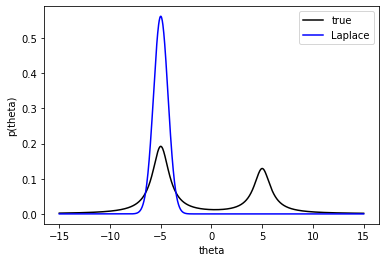

In [6]:
est_laplace = ss.norm.pdf(theta, max_val, std_est)

plt.plot(theta, p_theta, color='black', label='true')
plt.plot(theta, est_laplace, color='blue', label='Laplace')
plt.xlabel('theta')
plt.ylabel('p(theta)')
plt.legend()
plt.show()

## OK, let's find the normal distribution Q that minimizes KL(Q, P)

$$\mathrm{KL}(Q, P) = \mathbb{E}_q\log q(\theta) - \mathbb{E}_q \log p(\theta)$$

### Note we're not really doing "posterior inference" here, since we don't have data...

* In Variational inference, we are looking to minimize $\mathbb{E}_q\log q(\theta) - \mathbb{E}_q \log p(\theta|x)$
* This is equivalent to maximizing the ELBO, $\mathbb{E}_q\log p(\theta, x) - E_q \log q(\theta)$
* Here, we're not doing posterior inference, we're just matching distributions... there is no $x$ so the ELBO is the negative KL


### There are built-in methods for calculating the KL in tensorflow_probability. However, to make sure we understand what's going on, we're going to estimate it explicitly using samples from Q. 

In [7]:
mu = tf.Variable(initial_value = 0.) # mean of Q
sigma = tf.Variable(initial_value = 1.) # standard deviation of Q
learning_rate = 0.01
sample_size = 1000
max_steps = 1000

q_dist = tfp.distributions.Normal(loc=mu, scale=sigma)
samples = q_dist.sample(sample_size)

# target_dist is as before, I'm re-writing it for completeness
target_dist = tfp.distributions.Mixture(
    cat=tfp.distributions.Categorical(probs=[rho, 1.-rho]), # mixing proportions
    components=[
        tfp.distributions.Cauchy(loc=mu1, scale=gamma), # first mixture component
        tfp.distributions.Cauchy(loc=mu2, scale=gamma)  # second mixture component
    ]
)

E_log_p = tf.reduce_mean(target_dist.log_prob(samples))
E_log_q = tf.reduce_mean(q_dist.log_prob(samples))

kl_loss = E_log_q - E_log_p


# Optimizer

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(kl_loss)

In [8]:
with tf.Session() as sess:
    sess.run(fetches=tf.global_variables_initializer())
    obs_mu, obs_sigma = sess.run(fetches=[[mu], [sigma]]) # initial values
    obs_loss = sess.run(fetches =[kl_loss])
    
    
    for step in range(max_steps):
        ## generate samples from current q_dist
        sess.run(fetches=samples)
        
        # gradient step
        sess.run(fetches=train_op)
        new_mu, new_sigma = sess.run(fetches=[mu, sigma])
        
        # update loss
        new_loss = sess.run(fetches=kl_loss)
        loss_diff = np.abs(new_loss - obs_loss[-1])

        obs_mu.append(new_mu)
        obs_sigma.append(new_sigma)
        obs_loss.append(new_loss)
        
        if (step - 1) % 100 == 0:
            print('iteration {}: mu = {}, sigma = {}, loss = {}'.format(step, new_mu, new_sigma, new_loss))
            
print('Approximate with a normal with mean {}, std. dev. {}'.format(new_mu, new_sigma))

iteration 1: mu = -0.020009580999612808, sigma = 1.0199990272521973, loss = 2.8554906845092773
iteration 101: mu = -1.2394236326217651, sigma = 1.9521132707595825, loss = 1.7340331077575684
iteration 201: mu = -2.4384169578552246, sigma = 2.6169376373291016, loss = 1.0059614181518555
iteration 301: mu = -3.2100398540496826, sigma = 2.983344793319702, loss = 0.7529153823852539
iteration 401: mu = -3.6624724864959717, sigma = 3.2004644870758057, loss = 0.6926803588867188
iteration 501: mu = -3.9136605262756348, sigma = 3.353013277053833, loss = 0.6909706592559814
iteration 601: mu = -4.034156322479248, sigma = 3.4834492206573486, loss = 0.69053053855896
iteration 701: mu = -4.034433364868164, sigma = 3.612741231918335, loss = 0.6382009983062744
iteration 801: mu = -3.991302013397217, sigma = 3.763044595718384, loss = 0.6903719902038574
iteration 901: mu = -3.8700525760650635, sigma = 3.935600519180298, loss = 0.6359961032867432
Approximate with a normal with mean -3.6893231868743896, std

## Let's see how that looks

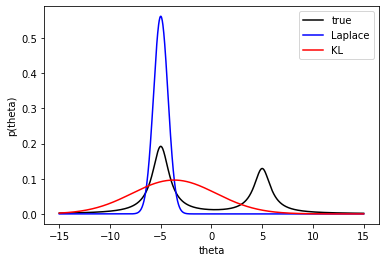

In [9]:
est_kl = ss.norm.pdf(theta, new_mu, new_sigma)
plt.plot(theta, p_theta, color='black', label='true')
plt.plot(theta, est_laplace, color='blue', label='Laplace')
plt.plot(theta, est_kl, color='red', label='KL')
plt.xlabel('theta')
plt.ylabel('p(theta)')
plt.legend()
plt.show()

# Let's move on to actual approximate Bayesian inference

## We're going to start by looking at a very simple linear regression dataset

remission.csv looks at cancer remission ('r') in terms of cell length ('LI')

Let's start by looking at the data

   Unnamed: 0   LI  m  r
0           1  0.4  1  0
1           2  0.4  1  0
2           3  0.5  1  0
3           4  0.5  1  0
4           5  0.6  1  0


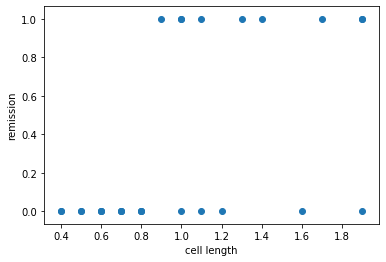

In [10]:
df = pd.read_csv("https://vincentarelbundock.github.io/Rdatasets/csv/boot/remission.csv")
print(df.head())

plt.scatter(df['LI'], df['r'])
plt.xlabel('cell length')
plt.ylabel('remission')
plt.show()

In [11]:
# Extracting the relevant variables into numpy arrays

X_obs = np.ones((len(df), 2))
X_obs[:, 1] = df['LI']
y_obs = [int(i == 1) for i in df['r']]
y_obs = np.array(y_obs)

## We're going to have to evaluate the (unnormalized) posterior. 

Here, we write a function to do so.

In [12]:
def sigmoid(x):
    return 1./(1. + np.exp(-x))

def logprob(beta, X, y, mu0 = 0., sig0 = 1., include_prior = True):
    ## if include_prior is False, return just the log likelihood
    ## This assumes a spherical gaussian prior on beta
    
    probs = sigmoid(np.dot(X, beta))
    lp1 = np.log(probs)
    lp0 = np.log(1-probs)
    lp = np.sum(lp1*y + lp0*(1-y)) 
    if include_prior:
        lp += np.sum(ss.norm.logpdf(beta, loc=mu0, scale=sig0))
    return lp

def plot_probs(beta, color='red', label=None):
    axes = plt.gca()
    x_lim = np.array(axes.get_xlim())
    xx = np.linspace(x_lim[0], x_lim[1], 100)
    yy = sigmoid(beta[0] + beta[1]*xx)
    plt.plot(xx, yy, color=color, label=label)

### Let's take a look at the ML estimate and the MAP estimate

Fill in the partial code below. Pick whatever values for mu_0 and sigma_0 that you want

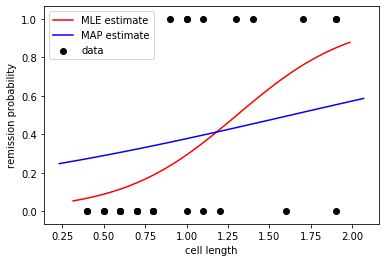

In [13]:
beta_hat_ml = minimize((lambda x: -1*logprob(x, X_obs, y_obs, include_prior=False)), x0=np.zeros(2)).x
mu0 = 0.# 
sig0 = 1.
beta_hat_map = minimize((lambda x: -1*logprob(x, X_obs, y_obs, include_prior=True)), x0=np.zeros(2)).x # fill in (you can use the max likelihood minimizer as a template)


plt.scatter(df['LI'], df['r'], label='data', color='black')
plot_probs(beta_hat_ml, color='red', label='MLE estimate')
plot_probs(beta_hat_map, color='blue', label='MAP estimate')
plt.xlabel('cell length')
plt.ylabel('remission probability')
plt.legend()
plt.show()

## Next, let's calculate the Laplace approximation.

We already have the MAP. We could calculate the Hessian by hand, or we can use automatic differentiation.

Fill in any gaps in the code below

### Bonus question: Calculate the Hessian by hand, and compare with the solution below

In [14]:
# first create a variable wrapper for the MAP, for calculating gradients
max_beta = tf.Variable(np.expand_dims(beta_hat_map, axis=1), dtype=tf.float32)

# We're also going to need variable wrappers for the data, since the log posterior is a function of the data
X = tf.Variable(X_obs, dtype=tf.float32)
y = tf.Variable(np.expand_dims(y_obs, axis=1), dtype=tf.float32)

# specify target log distribution: log(prior) + log(likelihood). 
# (fill in the TODO gaps below)

lik_dist = tfp.distributions.Bernoulli(logits=tf.matmul(X, max_beta))#<TODO>, <TODO>))

prior_dist = tfp.distributions.Normal(loc= mu0,scale=sig0)#<TODO>, scale= <TODO>)

log_lik = tf.reduce_sum(lik_dist.log_prob(value=y)) # sum of the log likelihoods for each value of y
log_prior = tf.reduce_sum(prior_dist.log_prob(value=max_beta))#<TODO> # use the log_lik above as a template... what are we evaluating the probability of here?
neg_log_prob = -1.0 * (log_lik + log_prior)


hess = tf.hessians(neg_log_prob, max_beta)
with tf.Session() as sess:
    sess.run(fetches=tf.global_variables_initializer())
    obs_hess = np.squeeze(sess.run(fetches=hess))
    
cov_laplace = np.linalg.inv(obs_hess)
print('approximate with a Normal distribution with mean {}, covariance \n{}'.format(beta_hat_map, cov_laplace))



approximate with a Normal distribution with mean [-1.29533189  0.79512483], covariance 
[[ 0.38386142 -0.2747126 ]
 [-0.27471256  0.30885312]]


## Let's compare with the true (unnormalized) posterior



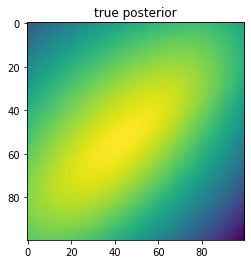

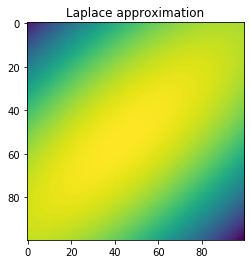

In [15]:
xlist = np.linspace(-10, 10, 100)
ylist = np.linspace(-10, 10, 100)
xgrid, ygrid = np.meshgrid(xlist, ylist)
Z1 = [[logprob([bx, by], X_obs, y_obs, mu0=mu0, sig0=sig0) for bx in xlist] for by in ylist]

plt.imshow(Z1)
plt.title('true posterior')
plt.show()


Z2 = [[ss.multivariate_normal.logpdf([bx, by], mean=beta_hat_map, cov=cov_laplace) for bx in xlist] 
                                     for by in ylist]
plt.imshow(Z2)
plt.title('Laplace approximation')
plt.show()

## Let's now try with Variational Bayes

We're now working with a posterior, so instead of minimizing the KL directly, we maximize the ELBO

We're going to use the tensorflow probability FFNN layers as our distributions. These  incorporate a bias, so unlike previously, we won't include an explicit 1 in our data representation

The DenseFlipout layers use an estimator called the Flipout Monte Carlo estimator to estimate expectations - we don't need to do it explicitly like we did before. 


In [16]:
# Start by creating an iterator for our data 
# (not really necessary in such a small example, but including for completeness)

def minibatch(x, y, batch_size=None):
    if batch_size is None:
        batch_size = len(y) # don't minibatch, use whole data
    training_dataset = tf.data.Dataset.from_tensor_slices((x, y))
    training_batches = training_dataset.repeat().batch(batch_size)
    training_iterator = tf.data.make_one_shot_iterator(training_batches)
    batch_features, batch_labels = training_iterator.get_next()
    return batch_features, batch_labels

In [17]:
## previously, we explicitly represented the bias using a column in X; here, we'll add a bias in Tensorflow

## I'm using the whole data in each minibatch (batch_size=None), since the data is small
features, labels = minibatch(X_obs[:, [1]], y_obs)

In [18]:
## flipout layers use a Flipout Monte Carlo estimator to estimate expectations
    ## The layer is defined as a linear regression (activation = None)
layer = tfp.layers.DenseFlipout(
    units=1,
    activation=None,
    kernel_posterior_fn=tfp.layers.default_mean_field_normal_fn(), # defining q for slope
    bias_posterior_fn=tfp.layers.default_mean_field_normal_fn()) # defining q for bias
logits = layer(features)
labels_distribution = tfp.distributions.Bernoulli(logits=logits)

W0622 19:50:55.752112 4715898304 deprecation.py:323] From /Users/williamsons/Library/Python/3.6/lib/python/site-packages/tensorflow_probability/python/layers/util.py:103: Layer.add_variable (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.add_weight` method instead.
W0622 19:50:55.771482 4715898304 deprecation.py:506] From /Users/williamsons/Library/Python/3.6/lib/python/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1624: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [19]:
## We need to optimize the ELBO, so need to calculate it (averaged over training data)
num_examples = len(y_obs) # size of training dataset

neg_log_likelihood = -tf.reduce_mean(input_tensor=labels_distribution.log_prob(labels))
kl = sum(layer.losses) / num_examples  ## E_q log(q(theta)) - E_q log(p(theta)) -- scaled to be on appropriate scale
elbo_loss = neg_log_likelihood + kl

In [20]:
## let's track training accuracy
predictions = tf.cast(logits > 0, dtype=tf.int32)
accuracy, accuracy_update_op = tf.compat.v1.metrics.accuracy(
      labels=labels, predictions=predictions)

## set up the optimizer
optimizer = tf.train.AdamOptimizer(
        learning_rate=0.01)
train_op = optimizer.minimize(loss=elbo_loss)

init_op = tf.group(tf.global_variables_initializer(),
                     tf.local_variables_initializer())


max_steps = 2000
with tf.Session() as sess:
    sess.run(init_op)

    # Fit the model to data.
    for step in range(max_steps):
      _ = sess.run([train_op, accuracy_update_op])
      if step % 100 == 0:
        
        loss_value, accuracy_value = sess.run([elbo_loss, accuracy])
        print("Step: {:>3d} Loss: {:.3f} Accuracy: {:.3f}".format(
            step, loss_value, accuracy_value))
        
    final_kernel_posterior = np.squeeze(sess.run(fetches=[layer.kernel_posterior.mean(), 
                                                          layer.kernel_posterior.stddev()]))
    final_bias_posterior = np.squeeze(sess.run(fetches=[layer.bias_posterior.mean(), 
                                                       layer.bias_posterior.stddev()]))
    
    
vb_mean = [final_bias_posterior[0], final_kernel_posterior[0]]
vb_cov = np.diag([final_bias_posterior[1], final_bias_posterior[1]])


print('approximate with a Normal distribution with mean {}, covariance \n{}'.format(vb_mean, vb_cov))



W0622 19:50:56.344455 4715898304 deprecation.py:323] From /Users/williamsons/Library/Python/3.6/lib/python/site-packages/tensorflow_core/python/training/optimizer.py:172: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


Step:   0 Loss: 0.750 Accuracy: 0.667
Step: 100 Loss: 0.708 Accuracy: 0.667
Step: 200 Loss: 0.680 Accuracy: 0.667
Step: 300 Loss: 0.713 Accuracy: 0.670
Step: 400 Loss: 0.666 Accuracy: 0.672
Step: 500 Loss: 0.666 Accuracy: 0.673
Step: 600 Loss: 0.710 Accuracy: 0.673
Step: 700 Loss: 0.676 Accuracy: 0.674
Step: 800 Loss: 0.663 Accuracy: 0.674
Step: 900 Loss: 0.660 Accuracy: 0.674
Step: 1000 Loss: 0.669 Accuracy: 0.674
Step: 1100 Loss: 0.700 Accuracy: 0.674
Step: 1200 Loss: 0.668 Accuracy: 0.674
Step: 1300 Loss: 0.674 Accuracy: 0.674
Step: 1400 Loss: 0.706 Accuracy: 0.674
Step: 1500 Loss: 0.659 Accuracy: 0.675
Step: 1600 Loss: 0.660 Accuracy: 0.675
Step: 1700 Loss: 0.661 Accuracy: 0.674
Step: 1800 Loss: 0.661 Accuracy: 0.675
Step: 1900 Loss: 0.660 Accuracy: 0.674
approximate with a Normal distribution with mean [-0.6906267172396638, -0.018585939916254037], covariance 
[[0.00686497 0.        ]
 [0.         0.00686497]]


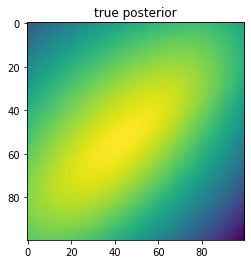

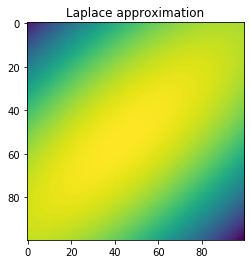

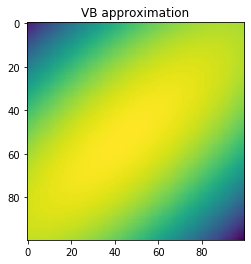

In [21]:
xlist = np.linspace(-10, 10, 100)
ylist = np.linspace(-10, 10, 100)
xgrid, ygrid = np.meshgrid(xlist, ylist)
Z1 = [[logprob([bx, by], X_obs, y_obs, mu0=mu0, sig0=sig0) for bx in xlist] for by in ylist]

plt.imshow(Z1)
plt.title('true posterior')
plt.show()


Z2 = [[ss.multivariate_normal.logpdf([bx, by], mean=beta_hat_map, cov=cov_laplace) for bx in xlist] 
                                     for by in ylist]
plt.imshow(Z2)
plt.title('Laplace approximation')
plt.show()


Z3 = [[ss.multivariate_normal.logpdf([bx, by], mean=vb_mean, cov=vb_cov) for bx in xlist] 
                                     for by in ylist]
plt.imshow(Z2)
plt.title('VB approximation')
plt.show()

### Bonus question

Look back to where we approximated the mixture model by minimizing the KL divergence

$$\mathrm{KL}(Q, P) =\mathbb{E}_q\log \frac{q(\theta)}{p(\theta)} =  \mathbb{E}_q\log q(\theta) - \mathbb{E}_q \log p(\theta)$$

This is going to be minimized when $q(\theta)=p(\theta) \; \forall \theta$.

When the distributions don't match, the KL is going to be small if $q(\theta)$ is small wherever $p(\theta)$ is small (so the ratio doesn't blow up). 

We can take the principles of variational inference, and use a different measure of similarity between $Q$ and $P$. For example, rather than looking at $\mathrm{KL}(Q, P)$, we could look at $KL(P, Q)$ (remember, KL divergence is asymmetric!) 

* Thinking about the above discussion, what do you think the solution that minimizes $KL(P, Q)$ will look like? Will it have higher or lower variance than the solution that minimizes $KL(Q, P)$?
* Try it out! Modify the variational inference code to minimize $KL(P, Q)$ and plot the result. Did it agree with your intuition?



iteration 1: mu = -0.019500460475683212, sigma = 1.0199477672576904, loss = 24.77747344970703
iteration 101: mu = -0.1311040222644806, sigma = 1.2847613096237183, loss = 74.16473388671875
iteration 201: mu = -0.304129421710968, sigma = 1.3352397680282593, loss = 35.84695816040039
iteration 301: mu = -0.3717597723007202, sigma = 1.4402145147323608, loss = 3468.398193359375
iteration 401: mu = -0.21245458722114563, sigma = 1.640160083770752, loss = 609.0099487304688
iteration 501: mu = -0.2658556401729584, sigma = 1.6470239162445068, loss = 9.745519638061523
iteration 601: mu = -0.2670818269252777, sigma = 1.6479923725128174, loss = 3632.080810546875
iteration 701: mu = -0.27521786093711853, sigma = 1.6484705209732056, loss = 72.62174987792969
iteration 801: mu = -0.35560959577560425, sigma = 1.662996530532837, loss = 20.56882667541504
iteration 901: mu = -0.3601040244102478, sigma = 1.6637370586395264, loss = 61.104522705078125
Approximate with a normal with mean -0.3238750398159027, st

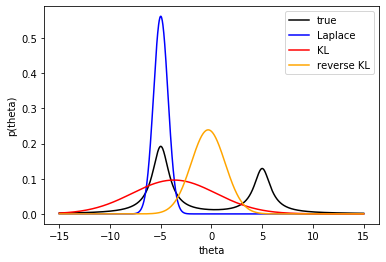

In [22]:
mu = tf.Variable(initial_value = 0.) # mean of Q
sigma = tf.Variable(initial_value = 1.) # standard deviation of Q
learning_rate = 0.01
sample_size = 100
max_steps = 1000

q_dist = tfp.distributions.Normal(loc=mu, scale=sigma)


# target_dist is as before, I'm re-writing it for completeness
target_dist_reverse = tfp.distributions.Mixture(
    cat=tfp.distributions.Categorical(probs=[rho, 1.-rho]), # mixing proportions
    components=[
        tfp.distributions.Cauchy(loc=mu1, scale=gamma), # first mixture component
        tfp.distributions.Cauchy(loc=mu2, scale=gamma)  # second mixture component
    ]
)
samples = target_dist_reverse.sample(sample_size)

E_log_p = tf.reduce_mean(target_dist_reverse.log_prob(samples))
E_log_q = tf.reduce_mean(q_dist.log_prob(samples))

kl_loss = E_log_p - E_log_q


# Optimizer

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(kl_loss)

with tf.Session() as sess:
    sess.run(fetches=tf.global_variables_initializer())
    obs_mu, obs_sigma = sess.run(fetches=[[mu], [sigma]]) # initial values
    obs_loss = sess.run(fetches =[kl_loss])
    
    
    for step in range(max_steps):
        ## generate samples from current q_dist
        sess.run(fetches=samples)
        
        # gradient step
        sess.run(fetches=train_op)
        new_mu, new_sigma = sess.run(fetches=[mu, sigma])
        
        # update loss
        new_loss = sess.run(fetches=kl_loss)
        loss_diff = np.abs(new_loss - obs_loss[-1])

        obs_mu.append(new_mu)
        obs_sigma.append(new_sigma)
        obs_loss.append(new_loss)
        
        if (step - 1) % 100 == 0:
            print('iteration {}: mu = {}, sigma = {}, loss = {}'.format(step, new_mu, new_sigma, new_loss))
            
print('Approximate with a normal with mean {}, std. dev. {}'.format(new_mu, new_sigma))

est_reverse_kl = ss.norm.pdf(theta, new_mu, new_sigma)
plt.plot(theta, p_theta, color='black', label='true')
plt.plot(theta, est_laplace, color='blue', label='Laplace')
plt.plot(theta, est_kl, color='red', label='KL')
plt.plot(theta, est_reverse_kl, color='orange', label='reverse KL')
plt.xlabel('theta')
plt.ylabel('p(theta)')
plt.legend()
plt.show()